In [17]:
# imports
import kagglehub
from kagglehub import KaggleDatasetAdapter
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.arima.model import ARIMA
import numpy as np
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from scipy.stats import zscore


# Load data 

In [20]:



# Set the path to the file you'd like to load
file_path = "GlobalWeatherRepository.csv"

# Load the latest version
df = kagglehub.load_dataset(
  KaggleDatasetAdapter.PANDAS,
  "nelgiriyewithana/global-weather-repository",
  file_path
  # Provide any additional arguments like 
  # sql_query or pandas_kwargs. See the 
  # documenation for more information:
  # https://github.com/Kaggle/kagglehub/blob/main/README.md#kaggledatasetadapterpandas
)

# print("First 5 records:", df.head())
df.head()

/tmp/ipykernel_156801/2419621237.py:5: DeprecationWarning: load_dataset is deprecated and will be removed in future version.
  df = kagglehub.load_dataset(


,country,location_name,latitude,longitude,timezone,last_updated_epoch,last_updated,temperature_celsius,temperature_fahrenheit,condition_text,...,air_quality_PM2.5,air_quality_PM10,air_quality_us-epa-index,air_quality_gb-defra-index,sunrise,sunset,moonrise,moonset,moon_phase,moon_illumination
0,Afghanistan,Kabul,34.52,69.18,Asia/Kabul,1715849100,2024-05-16 13:15,26.6,79.8,Partly Cloudy,...,8.4,26.6,1,1,04:50 AM,06:50 PM,12:12 PM,01:11 AM,Waxing Gibbous,55
1,Albania,Tirana,41.33,19.82,Europe/Tirane,1715849100,2024-05-16 10:45,19.0,66.2,Partly cloudy,...,1.1,2.0,1,1,05:21 AM,07:54 PM,12:58 PM,02:14 AM,Waxing Gibbous,55
2,Algeria,Algiers,36.76,3.05,Africa/Algiers,1715849100,2024-05-16 09:45,23.0,73.4,Sunny,...,10.4,18.4,1,1,05:40 AM,07:50 PM,01:15 PM,02:14 AM,Waxing Gibbous,55
3,Andorra,Andorra La Vella,42.50,1.52,Europe/Andorra,1715849100,2024-05-16 10:45,6.3,43.3,Light drizzle,...,0.7,0.9,1,1,06:31 AM,09:11 PM,02:12 PM,03:31 AM,Waxing Gibbous,55
4,Angola,Luanda,-8.84,13.23,Africa/Luanda,1715849100,2024-05-16 09:45,26.0,78.8,Partly cloudy,...,183.4,262.3,5,10,06:12 AM,05:55 PM,01:17 PM,12:38 AM,Waxing Gibbous,55


### Check for missing values

In [5]:
missing_values = df.isnull().sum()

# drop unnecessary duplicate columns
df_cleaned = df.drop(columns=["temperature_fahrenheit", "wind_mph", "pressure_in", "precip_in", 
                              "feels_like_fahrenheit", "visibility_miles", "gust_mph"])


# Convert date column to datetime format
df_cleaned["last_updated"] = pd.to_datetime(df_cleaned["last_updated"])


# Exploratory data analysis

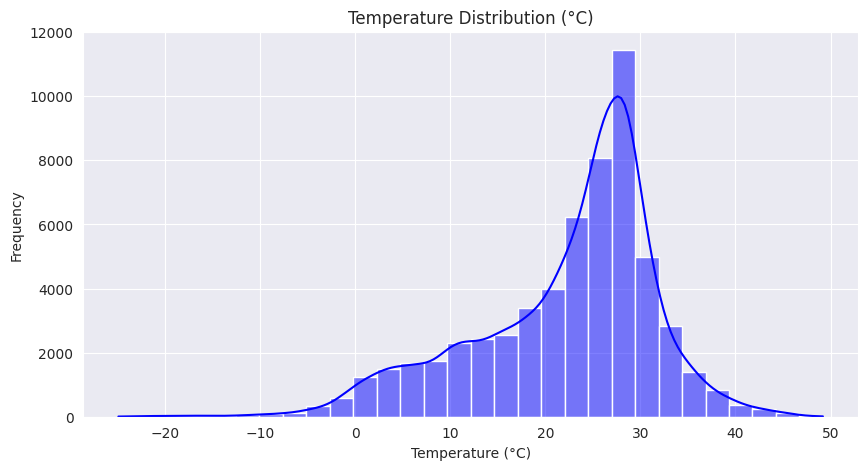

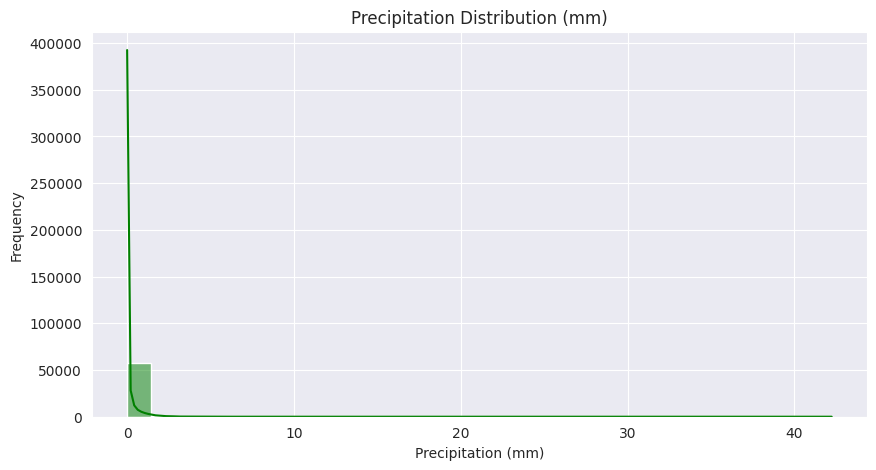

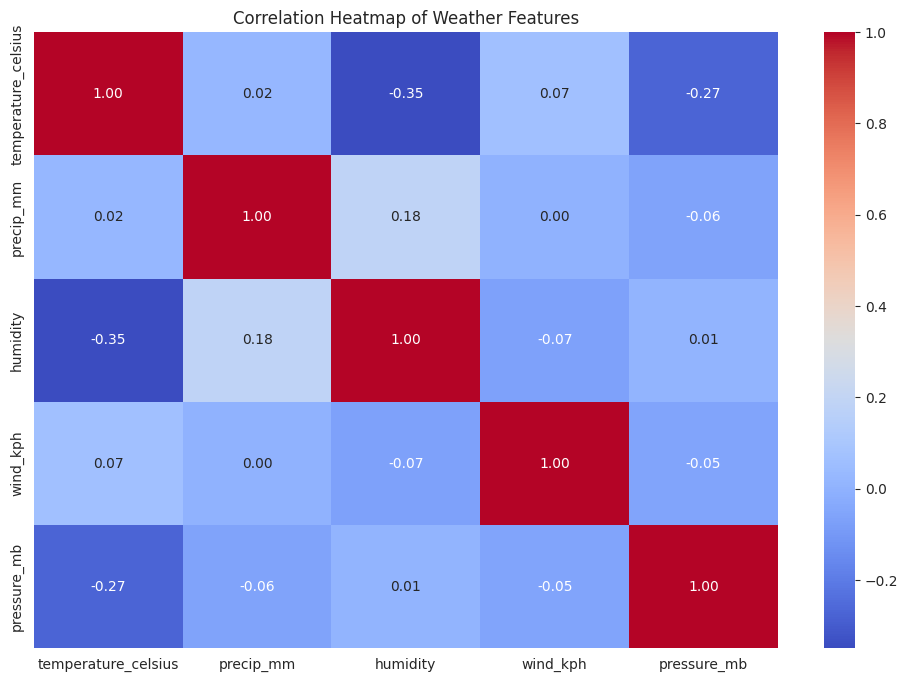

In [6]:


# Set style
sns.set_style("darkgrid")

# Plot temperature distribution
plt.figure(figsize=(10, 5))
sns.histplot(df_cleaned["temperature_celsius"], bins=30, kde=True, color="blue")
plt.title("Temperature Distribution (°C)")
plt.xlabel("Temperature (°C)")
plt.ylabel("Frequency")
plt.show()

# Plot precipitation distribution
plt.figure(figsize=(10, 5))
sns.histplot(df_cleaned["precip_mm"], bins=30, kde=True, color="green")
plt.title("Precipitation Distribution (mm)")
plt.xlabel("Precipitation (mm)")
plt.ylabel("Frequency")
plt.show()

# Correlation heatmap for key weather parameters
plt.figure(figsize=(12, 8))
correlation_matrix = df_cleaned[["temperature_celsius", "precip_mm", "humidity", "wind_kph", "pressure_mb"]].corr()
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap of Weather Features")
plt.show()


## EDA Insights:
# Temperature Distribution:
* Most temperatures are within a reasonable range, with a peak around 20-30°C.
* Some extreme values might indicate anomalies.

## Precipitation Distribution:
* Most areas have low precipitation, but a few locations experience heavy rainfall.

## Correlation Heatmap:
* Temperature and Humidity: Negative correlation (warmer regions tend to be less humid).
* Wind Speed and Pressure: Weak correlation, but worth exploring further.
* Precipitation and Humidity: Positive correlation (rainy conditions are usually humid)

# Model Building

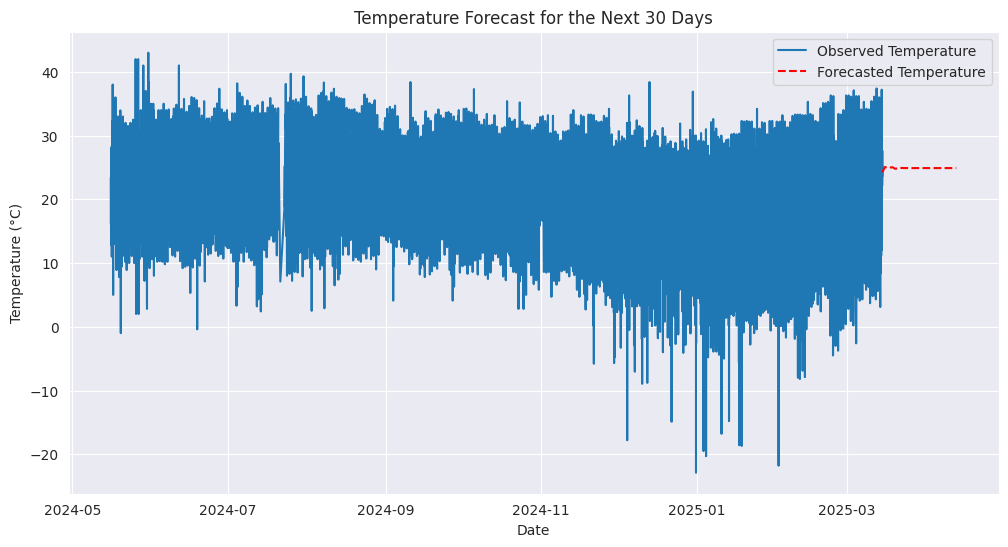

In [7]:


# Prepare time series data (aggregating global temperature over time)
df_time_series = df_cleaned.groupby("last_updated")["temperature_celsius"].mean().reset_index()

# Sort by date
df_time_series = df_time_series.sort_values("last_updated")

# Train an ARIMA model for forecasting
model = ARIMA(df_time_series["temperature_celsius"], order=(5,1,0))  # ARIMA(5,1,0) chosen arbitrarily
model_fit = model.fit()

# Forecast next 30 days
forecast_steps = 30
forecast = model_fit.forecast(steps=forecast_steps)

# Generate future dates
future_dates = pd.date_range(start=df_time_series["last_updated"].max(), periods=forecast_steps, freq="D")

# Plot forecast
plt.figure(figsize=(12, 6))
plt.plot(df_time_series["last_updated"], df_time_series["temperature_celsius"], label="Observed Temperature")
plt.plot(future_dates, forecast, label="Forecasted Temperature", linestyle="dashed", color="red")
plt.xlabel("Date")
plt.ylabel("Temperature (°C)")
plt.title("Temperature Forecast for the Next 30 Days")
plt.legend()
plt.show()


In [8]:

# Splitting the data into training and testing sets (80% train, 20% test)
train_size = int(len(df_time_series) * 0.8)
train, test = df_time_series[:train_size], df_time_series[train_size:]

# Train ARIMA on training data
model = ARIMA(train["temperature_celsius"], order=(5,1,0))
model_fit = model.fit()

# Predict on test data
test_forecast = model_fit.forecast(steps=len(test))

# Calculate evaluation metrics
mae = mean_absolute_error(test["temperature_celsius"], test_forecast)
rmse = np.sqrt(mean_squared_error(test["temperature_celsius"], test_forecast))

print(f"Model Performance:")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")


Model Performance:
Mean Absolute Error (MAE): 8.31
Root Mean Squared Error (RMSE): 9.78


# Using Seasonal Arima

In [9]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

sarima_model = SARIMAX(train["temperature_celsius"], order=(5,1,0), seasonal_order=(1,1,1,12))
sarima_fit = sarima_model.fit()

# Predict on test set
sarima_forecast = sarima_fit.forecast(steps=len(test))

# Evaluate
mae_sarima = mean_absolute_error(test["temperature_celsius"], sarima_forecast)
rmse_sarima = np.sqrt(mean_squared_error(test["temperature_celsius"], sarima_forecast))

print(f"SARIMA Performance: MAE = {mae_sarima:.2f}, RMSE = {rmse_sarima:.2f}")


SARIMA Performance: MAE = 9.99, RMSE = 11.58


# Using Facebook Prophet for Non-Linear Trends

In [10]:
# Load dataset
# df = pd.read_csv("GlobalWeatherRepository.csv")

# Convert last_updated to datetime and sort by date
df["last_updated"] = pd.to_datetime(df["last_updated"])
df = df.sort_values("last_updated")

# Select temperature as target variable
data = df[["last_updated", "temperature_celsius"]].dropna()

# Normalize temperature data
scaler = MinMaxScaler(feature_range=(0,1))
data["temperature_celsius"] = scaler.fit_transform(data[["temperature_celsius"]])

# Convert to numpy array
temperature_data = data["temperature_celsius"].values


In [11]:
def create_sequences(data, seq_length=30):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])  # Last 30 days
        y.append(data[i+seq_length])    # Next day's temperature
    return np.array(X), np.array(y)

seq_length = 30  # Use past 30 days to predict next day
X, y = create_sequences(temperature_data, seq_length)

# Reshape X for LSTM input (samples, time steps, features)
X = X.reshape((X.shape[0], X.shape[1], 1))


In [12]:
# tf.config.set_visible_devices([], 'GPU')  # Disable GPU

# Define LSTM model
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(seq_length, 1)),  # First LSTM layer
    Dropout(0.2),  
    LSTM(50, return_sequences=False),  # Second LSTM layer
    Dropout(0.2),
    Dense(25),  # Fully connected layer
    Dense(1)  # Output layer (predict temperature)
])

# Compile model
model.compile(optimizer="adam", loss="mean_squared_error")

# Train the model
history = model.fit(X, y, epochs=20, batch_size=16, validation_split=0.2)


I0000 00:00:1741964219.544090  156801 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5520 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4070 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9
/home/mojo/miniconda3/envs/tf-gpu/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20


I0000 00:00:1741964221.508871  157461 cuda_dnn.cc:529] Loaded cuDNN version 90300


2932/2932 ━━━━━━━━━━━━━━━━━━━━ 45s 15ms/step - loss: 0.0172 - val_loss: 0.0210
Epoch 2/20
2932/2932 ━━━━━━━━━━━━━━━━━━━━ 42s 14ms/step - loss: 0.0125 - val_loss: 0.0217
Epoch 3/20
2932/2932 ━━━━━━━━━━━━━━━━━━━━ 47s 16ms/step - loss: 0.0123 - val_loss: 0.0215
Epoch 4/20
2932/2932 ━━━━━━━━━━━━━━━━━━━━ 37s 13ms/step - loss: 0.0123 - val_loss: 0.0228
Epoch 5/20
2932/2932 ━━━━━━━━━━━━━━━━━━━━ 43s 15ms/step - loss: 0.0123 - val_loss: 0.0210
Epoch 6/20
2932/2932 ━━━━━━━━━━━━━━━━━━━━ 43s 15ms/step - loss: 0.0122 - val_loss: 0.0213
Epoch 7/20
2932/2932 ━━━━━━━━━━━━━━━━━━━━ 43s 15ms/step - loss: 0.0124 - val_loss: 0.0209
Epoch 8/20
2932/2932 ━━━━━━━━━━━━━━━━━━━━ 47s 16ms/step - loss: 0.0121 - val_loss: 0.0213
Epoch 9/20
2932/2932 ━━━━━━━━━━━━━━━━━━━━ 43s 15ms/step - loss: 0.0123 - val_loss: 0.0214
Epoch 10/20
2932/2932 ━━━━━━━━━━━━━━━━━━━━ 43s 15ms/step - loss: 0.0123 - val_loss: 0.0214
Epoch 11/20
2932/2932 ━━━━━━━━━━━━━━━━━━━━ 43s 15ms/step - loss: 0.0120 - val_loss: 0.0220
Epoch 12/20
2932/29

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━

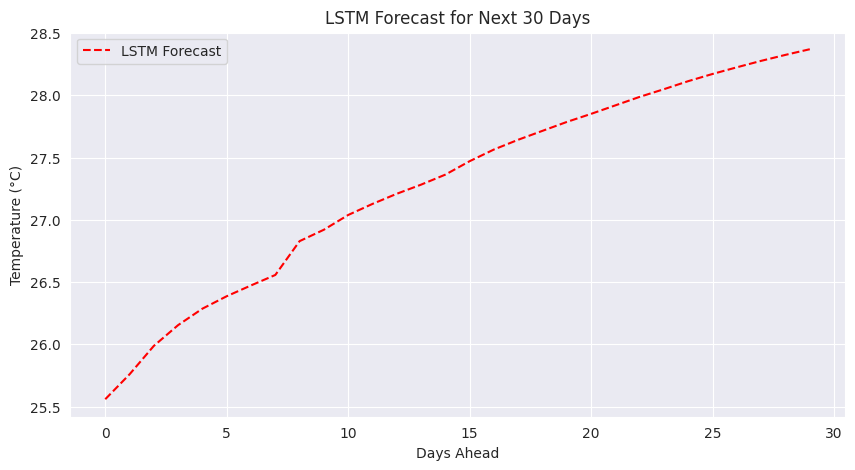

In [13]:
# Predict next 30 days
last_30_days = temperature_data[-seq_length:].reshape(1, seq_length, 1)  # Reshape for LSTM
predictions = []

for _ in range(30):  
    pred = model.predict(last_30_days)[0][0]  # Predict next day
    predictions.append(pred)
    
    # Update input sequence
    last_30_days = np.roll(last_30_days, -1)
    last_30_days[0, -1, 0] = pred

# Convert predictions back to original scale
predictions = scaler.inverse_transform(np.array(predictions).reshape(-1, 1))

# Plot results
plt.figure(figsize=(10,5))
plt.plot(predictions, label="LSTM Forecast", linestyle="dashed", color="red")
plt.xlabel("Days Ahead")
plt.ylabel("Temperature (°C)")
plt.title("LSTM Forecast for Next 30 Days")
plt.legend()
plt.show()


In [15]:
y_pred = model.predict(X)
y_pred = scaler.inverse_transform(y_pred)  # Convert back to original scale
y_actual = scaler.inverse_transform(y.reshape(-1, 1))  # Convert actual values back

# Calculate MAE and RMSE
mae = mean_absolute_error(y_actual, y_pred)
rmse = np.sqrt(mean_squared_error(y_actual, y_pred))

print(f"LSTM Model Performance:")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")


1833/1833 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step
LSTM Model Performance:
Mean Absolute Error (MAE): 6.71
Root Mean Squared Error (RMSE): 8.87


# Anomaly detection

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import zscore
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

In [25]:
df.columns

Index(['country', 'location_name', 'latitude', 'longitude', 'timezone',
       'last_updated_epoch', 'last_updated', 'temperature_celsius',
       'temperature_fahrenheit', 'condition_text', 'wind_mph', 'wind_kph',
       'wind_degree', 'wind_direction', 'pressure_mb', 'pressure_in',
       'precip_mm', 'precip_in', 'humidity', 'cloud', 'feels_like_celsius',
       'feels_like_fahrenheit', 'visibility_km', 'visibility_miles',
       'uv_index', 'gust_mph', 'gust_kph', 'air_quality_Carbon_Monoxide',
       'air_quality_Ozone', 'air_quality_Nitrogen_dioxide',
       'air_quality_Sulphur_dioxide', 'air_quality_PM2.5', 'air_quality_PM10',
       'air_quality_us-epa-index', 'air_quality_gb-defra-index', 'sunrise',
       'sunset', 'moonrise', 'moonset', 'moon_phase', 'moon_illumination'],
      dtype='object')

# Isolation forest

In [27]:
df["last_updated"] = pd.to_datetime(df["last_updated"])
df = df.sort_values("last_updated")

# Select relevant columns for anomaly detection
features = ["temperature_celsius", "humidity", "wind_mph", "precip_mm"]
df_filtered = df[features].dropna()


# Train Isolation Forest
iso_forest = IsolationForest(contamination=0.02, random_state=42)
df_filtered["anomaly_score"] = iso_forest.fit_predict(df_filtered)

# Extract anomalies
anomalies_iforest = df_filtered[df_filtered["anomaly_score"] == -1]

print(f"Total anomalies detected using Isolation Forest: {len(anomalies_iforest)}")


Total anomalies detected using Isolation Forest: 1174


# Z-Score Method (Statistical Anomaly Detection)

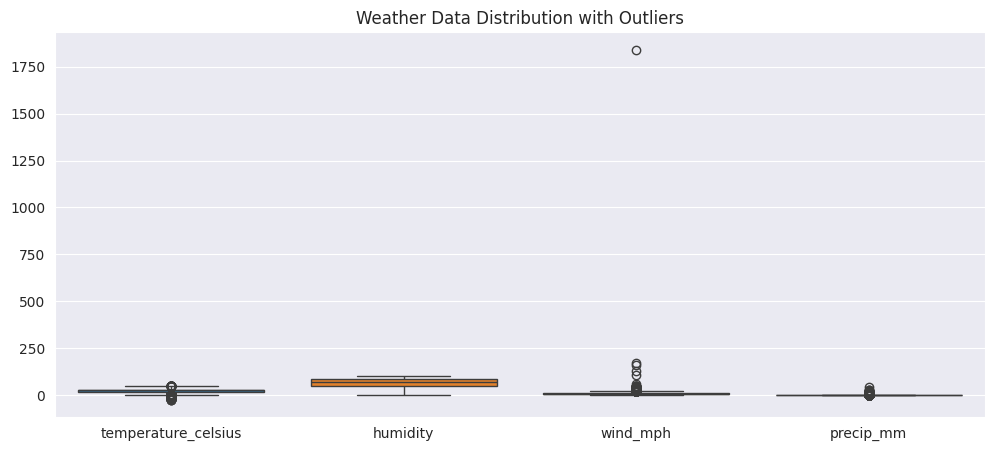

Total anomalies detected using Z-Score: 1088


In [29]:
# Convert last_updated to datetime and sort by date
df["last_updated"] = pd.to_datetime(df["last_updated"])
df = df.sort_values("last_updated")

# Select relevant columns for anomaly detection
features = ["temperature_celsius", "humidity", "wind_mph", "precip_mm"]
df_filtered = df[features].dropna()


# Compute Z-score
z_scores = np.abs(zscore(df_filtered))

# Identify anomalies (Z-score > 3)
anomalies_zscore = df_filtered[(z_scores > 3).any(axis=1)]

# Visualize anomalies
plt.figure(figsize=(12, 5))
sns.boxplot(data=df_filtered)
plt.title("Weather Data Distribution with Outliers")
plt.show()

print(f"Total anomalies detected using Z-Score: {len(anomalies_zscore)}")


In [30]:
# Normalize data
scaler = MinMaxScaler()
df_scaled = scaler.fit_transform(df_filtered.drop(columns=["anomaly_score"], errors="ignore"))

# Define Autoencoder
model = Sequential([
    Dense(16, activation="relu", input_shape=(df_scaled.shape[1],)),
    Dropout(0.2),
    Dense(8, activation="relu"),
    Dense(16, activation="relu"),
    Dense(df_scaled.shape[1], activation="linear")  # Reconstruct input
])

# Compile & train model
model.compile(optimizer="adam", loss="mse")
model.fit(df_scaled, df_scaled, epochs=20, batch_size=16, validation_split=0.2, verbose=0)

# Compute reconstruction error
reconstructed = model.predict(df_scaled)
errors = np.mean(np.abs(df_scaled - reconstructed), axis=1)

# Identify anomalies (Threshold: Top 2% highest errors)
threshold = np.percentile(errors, 98)
anomalies_autoencoder = df_filtered[errors > threshold]

print(f"Total anomalies detected using Autoencoder: {len(anomalies_autoencoder)}")


/home/mojo/miniconda3/envs/tf-gpu/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1741967324.152952  157460 service.cc:152] XLA service 0x1a013670 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1741967324.153224  157460 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 4070 Laptop GPU, Compute Capability 8.9
2025-03-14 11:48:44.197065: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1741967325.406187  157460 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process

1834/1834 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step
Total anomalies detected using Autoencoder: 1174
